### DEM Super Resolution Upscaling
The openly available SuperResolution model is from this paper: 2023 *"A Global-Information-Constrained Deep Learning Network for Digital Elevation Model Super-Resolution"* (https://www.mdpi.com/2072-4292/15/2/305)

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
# import libraries
import argparse
from skimage import io  
import os
import numpy as np
import math
import itertools
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
import glob
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
import time
import datetime
from torch.utils.tensorboard import SummaryWriter
import tifffile as tiff

# Train model

In [169]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        #修改代码 只扩大er倍
        for out_features in range(1):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                #尺度变换4*4 选用基于插值bicubic的Upsample替代PixelShuffle
                #nn.Upsample(scale_factor=2, mode='bicubic'),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=2, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out
class C(nn.Module):
    def __init__(self, input_shape):
        super(C, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def c_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(c_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)
    def forward(self, img):
        return self.model(img)
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, pred, truth):
        return  torch.sqrt(torch.mean((pred-truth)**2))
        torch.square((pred-truth)**2)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [170]:
from PIL import Image
class ImageDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.files = sorted(glob.glob(root + "/m*.*"))
    def __getitem__(self, index):
        img = io.imread(self.files[index % len(self.files)])
        min_value = np.min(img)
        abs_min_value = np.abs(min_value)
        shifted_img = img + abs_min_value
        img_ts = self.lr_transform(shifted_img)
        img_ts = (img_ts - 0) / ((103302.82 - 0) / 2) - 1
        w = img_ts.shape[2]//2
        img_lr = img_ts[:, :,w:]
        img_hr = img_ts[:, :,:w]
        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [88]:
#! pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Make train dataset

## Our original image

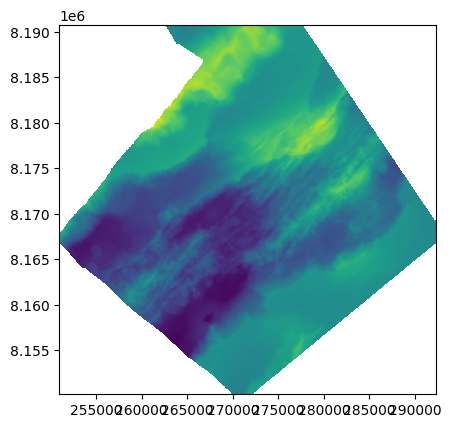

<Axes: >

In [171]:
import rasterio
from rasterio.plot import show
fp = r'/content/drive/MyDrive/GISR_code/images/Bathy_AOI_1_25m.tif'
img = rasterio.open(fp)
show(img)

In [172]:
img.width

1653

In [173]:
img.height

1624

In [176]:
img_hr = img.read()[0]

In [177]:
img_hr.shape

(1624, 1653)

In [178]:
#used for naormalization
min(img_hr.flatten())

-3303.82

In [179]:
max(img_hr.flatten())

99999.0

## Split image to n 64*64 images

In [180]:
M,N=64,64
images_tiles = [img_hr[x:x+M,y:y+N] for x in range(0,img_hr.shape[0],M) for y in range(0,img_hr.shape[1],N)]

In [185]:
#we get 676 images
len(images_tiles)

676

In [1]:
# for i in images_tiles:
#   print(i.shape)

In [ ]:
#save images
index=0
path="/content/drive/MyDrive/GISR_code/dataset/"
for img in  images_tiles:
  if img.shape==(64,64):
    tiff.imwrite(path +'/'+'hr_'+ str(index) + '.tif', img)
    index+=1

## Visualization of examples from High-resolution (HR) images

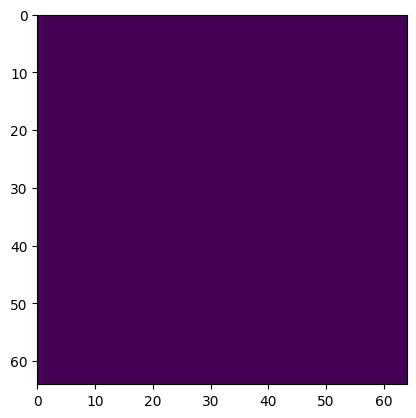

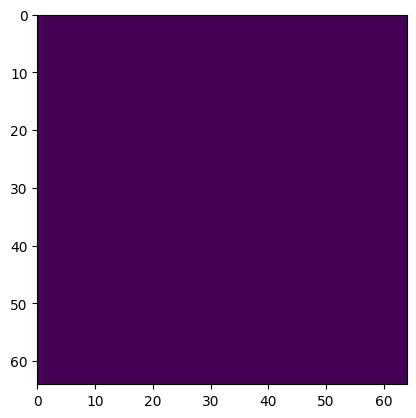

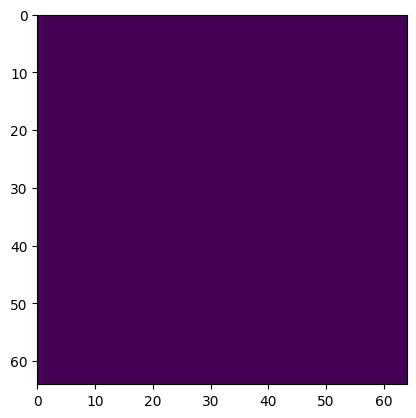

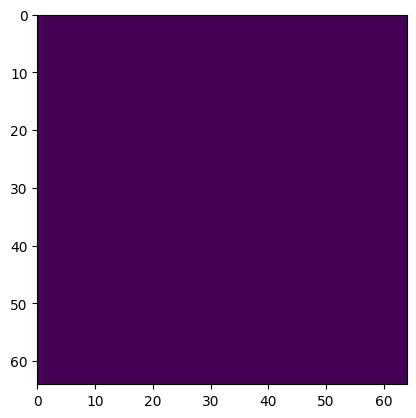

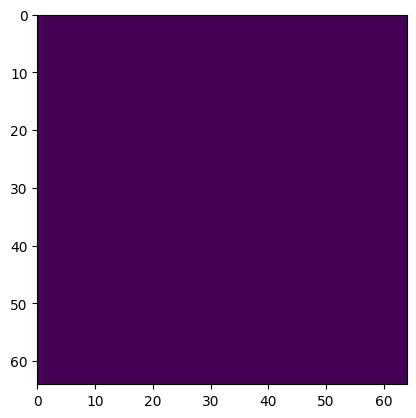

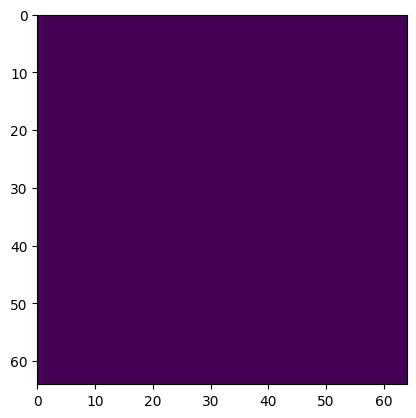

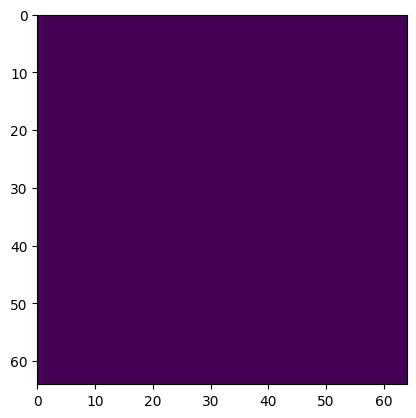

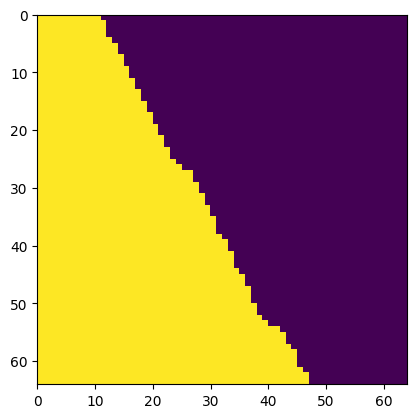

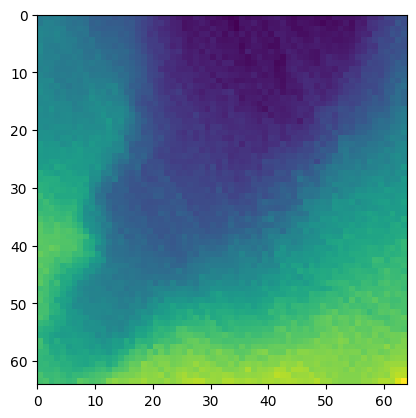

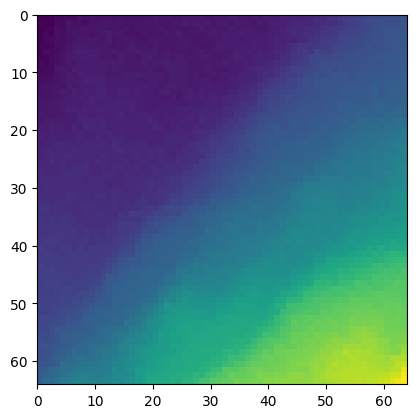

In [186]:
for index in range(10):
  fp = r'/content/drive/MyDrive/GISR_code/dataset/hr_'+ str(index) + '.tif'
  img = rasterio.open(fp)
  show(img)

## Extract Low-resolution (LR) images from HR images

In [ ]:
#!pip install -q condacolab
#import condacolab
#condacolab.install()
#!mamba install -q gdal=3.4.1
#from osgeo import gdal
#gdal.VersionInfo()

In [187]:
from osgeo import gdal
from scipy import ndimage

In [190]:
for image_index in range(len(images_tiles)):
  dataset = gdal.Open('/content/drive/MyDrive/GISR_code/dataset/hr_'+ str(index) + '.tif', gdal.GA_ReadOnly)

  # Read the elevation data
  elevation_data = dataset.GetRasterBand(1).ReadAsArray()

  # Define the new resolution
  new_resolution = 0.5  # Example: half the resolution

  # Compute the new size
  original_height, original_width = elevation_data.shape
  new_height = int(original_height * new_resolution)
  new_width = int(original_width * new_resolution)

  # Rescale the image using KNN interpolation
  downscaled_data = np.zeros((new_height, new_width))
  for i in range(new_height):
      for j in range(new_width):
          # Calculate the corresponding pixel coordinates in the original image
          x = int(i / new_resolution)
          y = int(j / new_resolution)
          downscaled_data[i, j] = elevation_data[x, y]  # Assign the value from the nearest neighbor
  downsampled_dem = downscaled_data
  # Define the upsampling factor
  upsample_factor = 2  # Change this value as needed
  # Compute the dimensions of the upsampled image
  #upsampled_shape = tuple(dim * upsample_factor for dim in downsampled_dem.shape)
  # Upsample the image using cubic interpolation
  upsampled_dem = ndimage.zoom(downsampled_dem, upsample_factor, order=0)
  #concatenate hr image with lr image
  image=np.concatenate((elevation_data,upsampled_dem), axis=1)
  tiff.imwrite('/content/drive/MyDrive/GISR_code/dataset/m'+str(image_index)+'.tif', image)


## Plot examples from the dataset

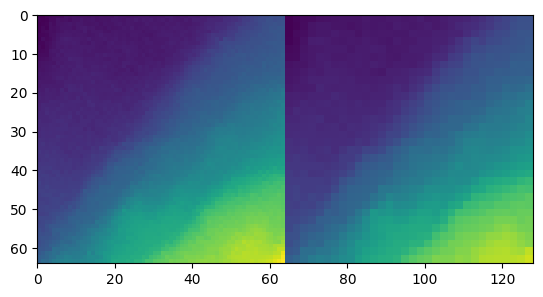

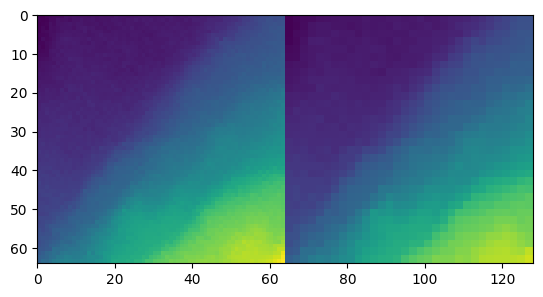

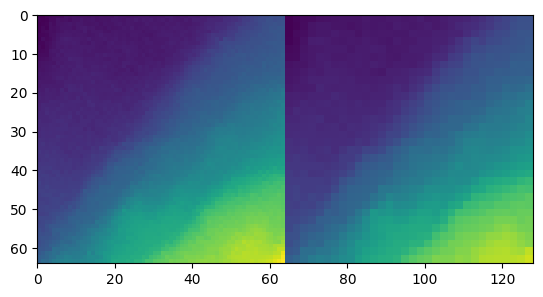

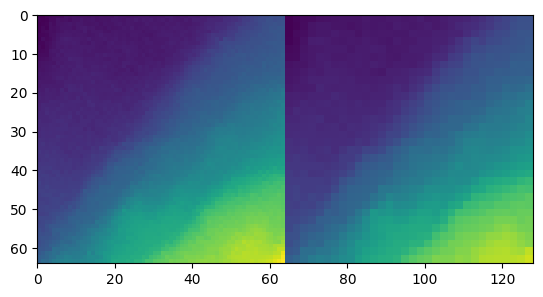

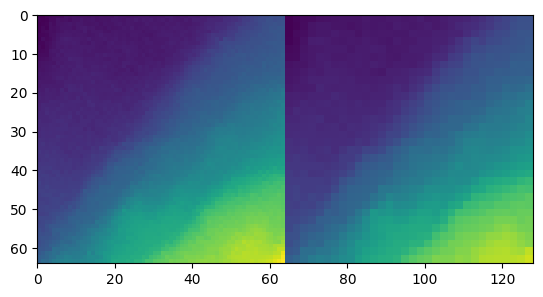

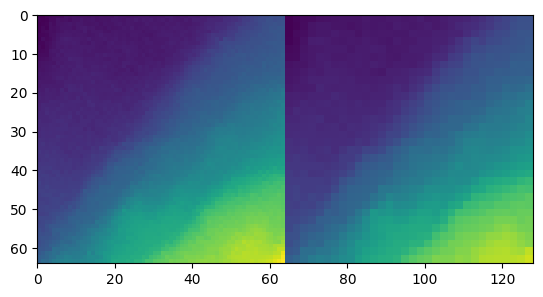

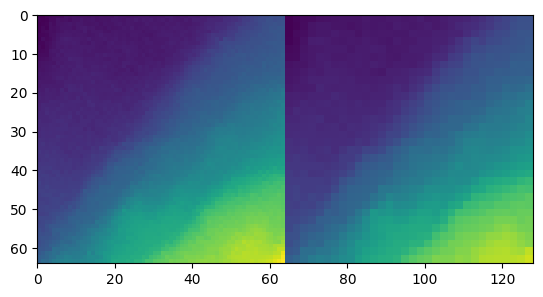

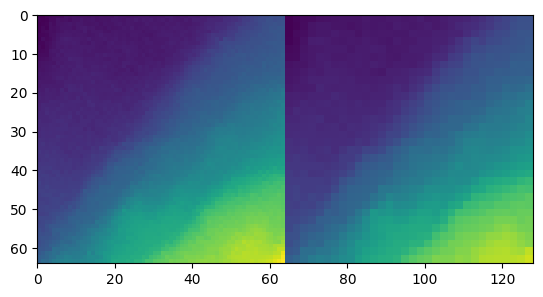

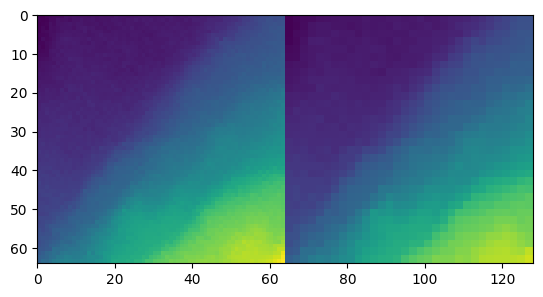

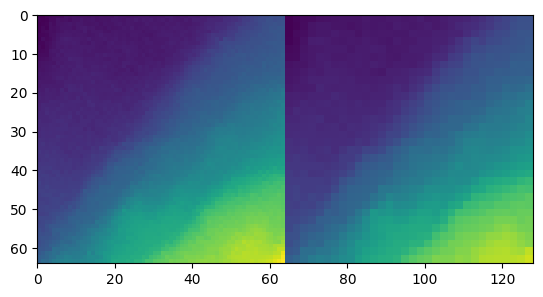

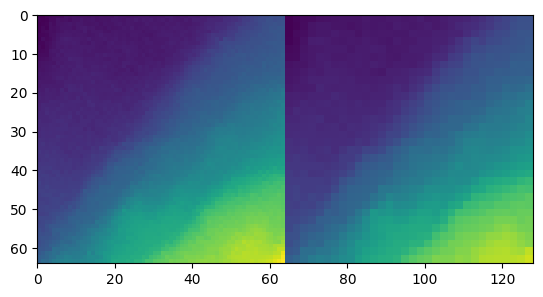

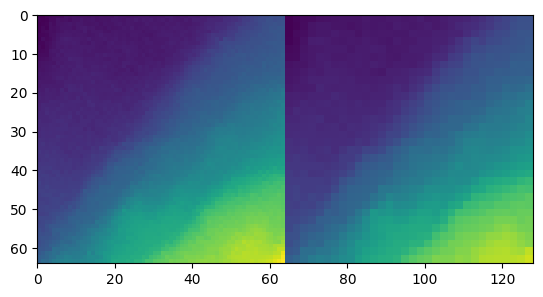

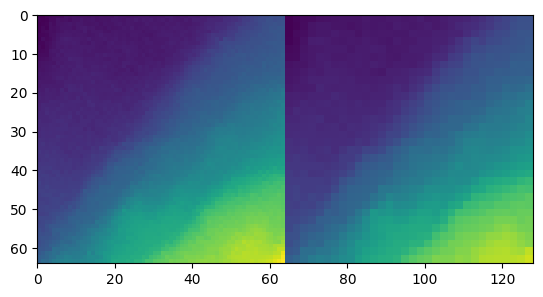

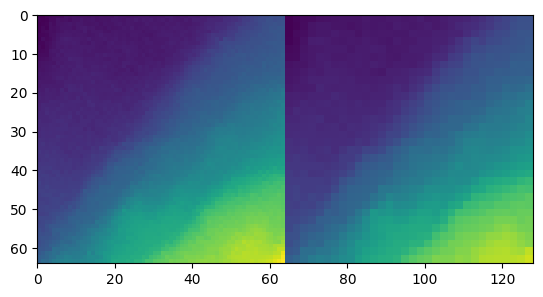

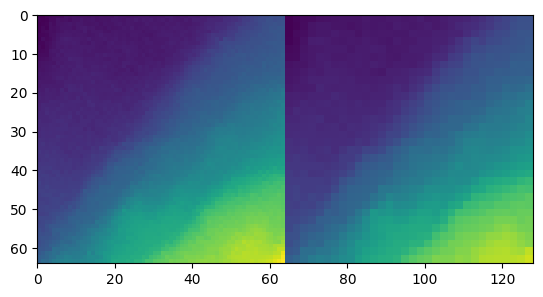

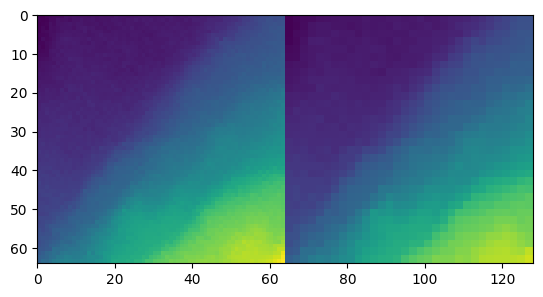

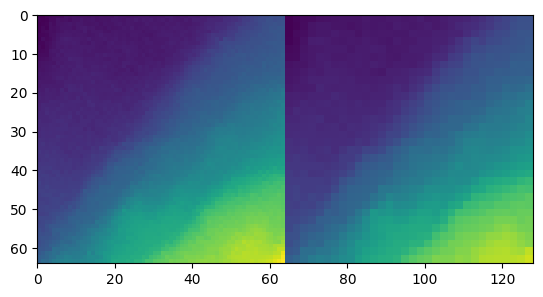

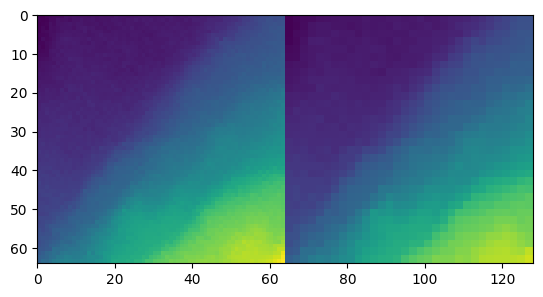

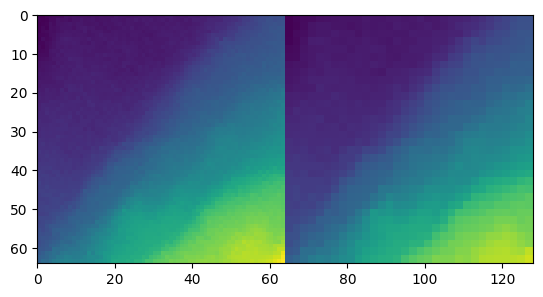

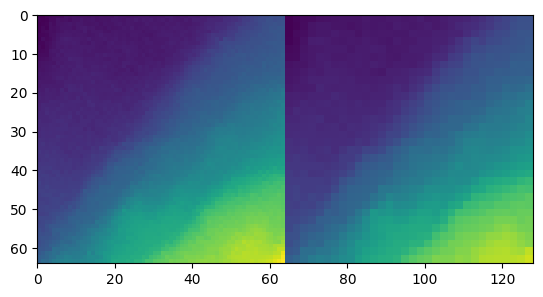

In [192]:
for index in range(20):
  fp = r'/content/drive/MyDrive/GISR_code/dataset/m'+ str(index) + '.tif'
  img = rasterio.open(fp)
  show(img)

# Train the model

In [197]:

DATBASE_PATH = r"/content/drive/MyDrive/GISR_code/dataset/"
epoch=99     #epoch to start training from
n_epochs=250     #number of epochs of training
batch_size=16    #size of the batches
lr=0.0002         #adam: learning rate
b1=0.5      #decay of first order momentum of gradient
b2=0.999    #help="adam: decay of first order momentum of gradient
decay_epoch=100      #help="epoch from which to start lr decay
n_cpu=0   #help="number of cpu threads to use during batch generation
hr_height=64    #high resolution image height
hr_width=64      #high resolution image width
channels=1         #number of image channels
sample_interval=100              #interval between saving image samples")
checkpoint_interval=10         #interval between model checkpoints

In [199]:

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)
generator = GeneratorResNet()
c= C(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

feature_extractor.eval()

criterion_r=RMSELoss()

criterion_content = torch.nn.L1Loss()


if cuda:
    generator = generator.cuda()
    c = c.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_r = criterion_r.cuda()
    criterion_content = criterion_content.cuda()

if epoch != 0:
    generator.load_state_dict(torch.load("/content/drive/MyDrive/GISR_code/GISR_checkpoint/generator_90.pth"))

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_C = torch.optim.Adam(c.parameters(), lr=lr*0.1, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

dataloader = DataLoader(
    ImageDataset(DATBASE_PATH, hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)
writer = SummaryWriter(DATBASE_PATH+'/logs')

In [200]:
loss=[]
for epoch in range(epoch, n_epochs):
    start = time.time()
    for i, imgs in enumerate(dataloader):

        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *c.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *c.output_shape))), requires_grad=False)
        optimizer_G.zero_grad()
        gen_hr = generator(imgs_lr)
        gen_hr = (gen_hr + imgs_lr)/2
        loss_r = criterion_r(c(gen_hr), valid)
        real_dem_3c = torch.cat((imgs_hr,imgs_hr,imgs_hr),1)
        gen_dem_3c = torch.cat((gen_hr, gen_hr, gen_hr), 1)

        gen_features = feature_extractor(gen_dem_3c)
        real_features = feature_extractor(real_dem_3c)
        loss_content = criterion_content(gen_features, real_features.detach())
        loss_RMSE = criterion_r(imgs_hr, gen_hr)

        loss_G = loss_content + 1e-3 * loss_r+10*loss_RMSE
        loss_G.backward()
        optimizer_G.step()

        optimizer_C.zero_grad()
        loss_real = criterion_r(c(imgs_hr), valid)
        loss_fake = criterion_r(c(gen_hr.detach()), fake)

        loss_C = (loss_real + loss_fake) / 2
        if i%3==0:
            loss_C.backward()
            optimizer_C.step()
        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d]  [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader),loss_G.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            writer.add_scalar('loss_G', loss_G.item(), batches_done)
            writer.add_scalar('loss_RMSE', loss_RMSE.item(), batches_done)
            img_grid = torch.cat((imgs_lr, gen_hr,imgs_hr), -1)
            save_image(img_grid, DATBASE_PATH+"/%d.png" % batches_done, normalize=False)
    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1 ,
                                                           time.time() - start))
    loss.append(loss_G)
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(),"/content/drive/MyDrive/GISR_code/models/generator_%d.pth" % epoch)

[Epoch 99/250] [Batch 0/42]  [G loss: 0.204323][Epoch 99/250] [Batch 1/42]  [G loss: 0.147487][Epoch 99/250] [Batch 2/42]  [G loss: 0.106348][Epoch 99/250] [Batch 3/42]  [G loss: 0.072343][Epoch 99/250] [Batch 4/42]  [G loss: 0.045856][Epoch 99/250] [Batch 5/42]  [G loss: 0.027401][Epoch 99/250] [Batch 6/42]  [G loss: 0.016630][Epoch 99/250] [Batch 7/42]  [G loss: 0.010765][Epoch 99/250] [Batch 8/42]  [G loss: 0.008060][Epoch 99/250] [Batch 9/42]  [G loss: 0.006889][Epoch 99/250] [Batch 10/42]  [G loss: 0.006227][Epoch 99/250] [Batch 11/42]  [G loss: 0.005890][Epoch 99/250] [Batch 12/42]  [G loss: 0.005710][Epoch 99/250] [Batch 13/42]  [G loss: 0.005502][Epoch 99/250] [Batch 14/42]  [G loss: 0.005366][Epoch 99/250] [Batch 15/42]  [G loss: 0.005264][Epoch 99/250] [Batch 16/42]  [G loss: 0.005148][Epoch 99/250] [Batch 17/42]  [G loss: 0.005065][Epoch 99/250] [Batch 18/42]  [G loss: 0.004990][Epoch 99/250] [Batch 19/42]  [G loss: 0.004942][Epoch 99/250] [Batch 20/42]  [G loss: 0.004875][E

In [201]:
loss_list = [tensor.item() for tensor in loss]

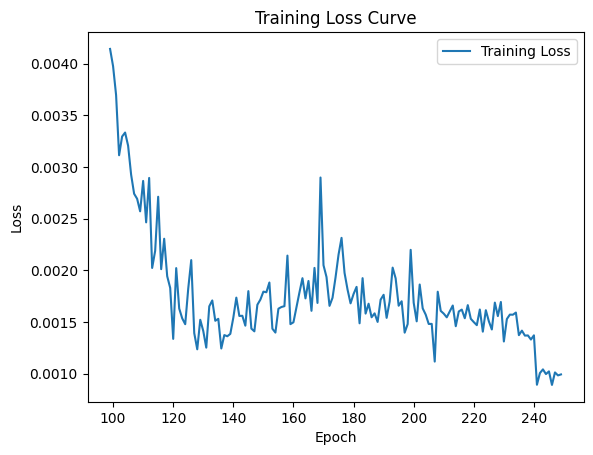

In [203]:
import matplotlib.pyplot as plt
# Plot the loss curve
x = range(99, 250)  
plt.plot(x, loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [208]:
!ls /content/drive/MyDrive/GISR_code/models/generator_*

/content/drive/MyDrive/GISR_code/models/generator_100.pth
/content/drive/MyDrive/GISR_code/models/generator_110.pth
/content/drive/MyDrive/GISR_code/models/generator_120.pth
/content/drive/MyDrive/GISR_code/models/generator_130.pth
/content/drive/MyDrive/GISR_code/models/generator_140.pth
/content/drive/MyDrive/GISR_code/models/generator_150.pth
/content/drive/MyDrive/GISR_code/models/generator_160.pth
/content/drive/MyDrive/GISR_code/models/generator_170.pth
/content/drive/MyDrive/GISR_code/models/generator_180.pth
/content/drive/MyDrive/GISR_code/models/generator_190.pth
/content/drive/MyDrive/GISR_code/models/generator_200.pth
/content/drive/MyDrive/GISR_code/models/generator_210.pth
/content/drive/MyDrive/GISR_code/models/generator_220.pth
/content/drive/MyDrive/GISR_code/models/generator_230.pth
/content/drive/MyDrive/GISR_code/models/generator_240.pth


 # Model testing 

In [205]:
import argparse
from skimage import io
import os
import numpy as np
import math
import itertools
import tifffile as tiff
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
import glob
import random
import torch
from torch.utils.data import Dataset
from PIL import Image
import time
import datetime
from torch.utils.tensorboard import SummaryWriter


In [206]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])
    def forward(self, img):
        return self.feature_extractor(img)
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(1):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                #nn.Upsample(scale_factor=2, mode='bicubic'),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=2, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out
class D(nn.Module):
    def __init__(self, input_shape):
        super(D, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def d_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(d_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, pred, truth):
        return  torch.sqrt(torch.mean((pred-truth)**2))
        torch.square((pred-truth)**2)

## Load the model

In [210]:
path = '/content/drive/MyDrive/GISR_code'#Your folder path
sample = "R1"#Your file name of tiff
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
lr = 0.0002
b1 = 0.5
b2 = 0.999
hr_height = 64
hr_width = 64
h=2335
l=304
cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)
generator = GeneratorResNet()
feature_extractor = FeatureExtractor()
feature_extractor.eval()
criterion_GAN = RMSELoss()
criterion_content = torch.nn.L1Loss()
if cuda:
    generator = generator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()
generator.load_state_dict(torch.load("/content/drive/MyDrive/GISR_code/models/generator_240.pth"))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor 

## Generate test data

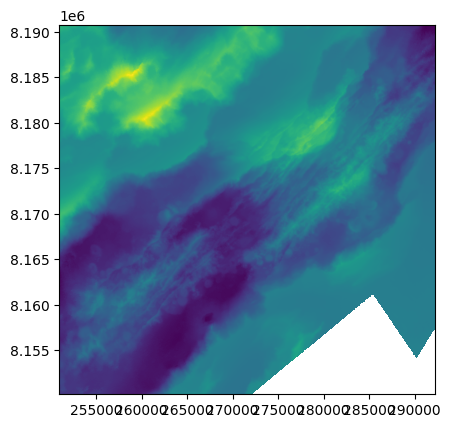

<Axes: >

In [211]:
import rasterio
from rasterio.plot import show
fp = r'/content/drive/MyDrive/GISR_code/images/Bathy_AOI_1_50m.tif'
img = rasterio.open(fp)
show(img)

In [212]:
img.width

826

In [213]:
img.height

812

In [216]:
img_lr = img.read()[0]

In [217]:
img_lr.shape

(812, 826)

## Split image into 64*64 images

In [218]:
M,N=64,64
images_tiles = [img_lr[x:x+M,y:y+N] for x in range(0,img_lr.shape[0],M) for y in range(0,img_lr.shape[1],N)]

In [219]:
#we get 169 images
len(images_tiles)

169

In [220]:
H,W=img_lr.shape
if W%M==0:
    n_w=int(W/M)
else:
    n_w=int(W/M)+1
if H%N==0:
    n_h=int(H/N)
else:
    n_h=int(H/N)+1

In [2]:
# for i in images_tiles:
#   print(i.shape)

# All tiles to  64x64

In [222]:
# There are some images that are not 64x64. The goal of this code is to transform all images to 64x64 without changing the information in the images.
new_tiles = []
N_w=n_w
new_tiles = []
tiles_index = []
operation_type = []
added_col_or_arr_number=[]
added_col_or_arr_number_last_tile=[]
images_tiles = [img_lr[x:x+M,y:y+N] for x in range(0,img_lr.shape[0],M) for y in range(0,img_lr.shape[1],N)]
for img_index in range(len(images_tiles)):
    if images_tiles[img_index].shape != (64, 64):
        if images_tiles[img_index].shape[0] == 64:
            # Add pixels (column) from previous tile
            n = 64 - images_tiles[img_index].shape[1]
            # Select the last n columns using negative indexing
            last_n_columns = images_tiles[img_index-1][:, -n:]
            # Create a new tile by horizontally stacking last_n_columns and images_tiles[img_index]
            new_tile = np.hstack((last_n_columns, images_tiles[img_index]))
            new_tiles.append(new_tile)
            tiles_index.append(img_index)
            operation_type.append('columns added')
            added_col_or_arr_number.append(n)
        if images_tiles[img_index].shape[1] == 64:
            # Add pixels (rows) from previous tile
            n = 64 - images_tiles[img_index].shape[0]
            # Select the last n rows using negative indexing
            last_n_rows = images_tiles[img_index-N_w][-n:, :]
            # Create a new tile by vertically stacking last_n_rows and images_tiles[img_index]
            new_tile = np.vstack((last_n_rows, images_tiles[img_index]))
            #images_tiles[img_index] = new_tile
            new_tiles.append(new_tile)
            tiles_index.append(img_index)
            operation_type.append('rows added')
            added_col_or_arr_number.append(n)
        if images_tiles[img_index].shape[1] != 64 and images_tiles[img_index].shape[0] != 64:
            index_=0
            for index in  tiles_index:
              images_tiles[index]=new_tiles[index_]
              index_+=1
            n_w_ = 64 - images_tiles[img_index].shape[1]
            # Select the last n columns using negative indexing
            last_n_columns = images_tiles[img_index-1][:, -n_w_:]
            # Create a new tile by horizontally stacking last_n_columns and images_tiles[img_index]
            new_tile_w = np.hstack((last_n_columns[-images_tiles[img_index].shape[0]:, :], images_tiles[img_index]))
            n_h_ = 64 - images_tiles[img_index].shape[0]
            # Select the last n rows using negative indexing
            last_n_rows = images_tiles[img_index-N_w][-n_h_:, :]
            # Create a new tile by vertically stacking last_n_rows and images_tiles[img_index]
            new_tile = np.vstack((last_n_rows, new_tile_w))
            # Replace the current tile with the new tile
            images_tiles[img_index] = new_tile
            tiles_index.append(img_index)
            operation_type.append('rows and columns added')
            added_col_or_arr_number_last_tile.append(n_w_)
            added_col_or_arr_number_last_tile.append(n_h_)      

In [223]:
#save images
index=0
path="/content/drive/MyDrive/GISR_code/dataset/"
for img in  images_tiles:
  tiff.imwrite(path +'/'+'lr_test_'+ str(index) + '.tif', img)
  index+=1

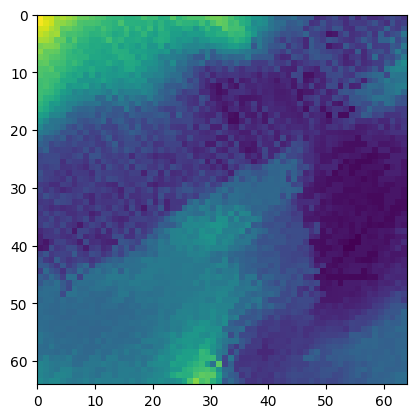

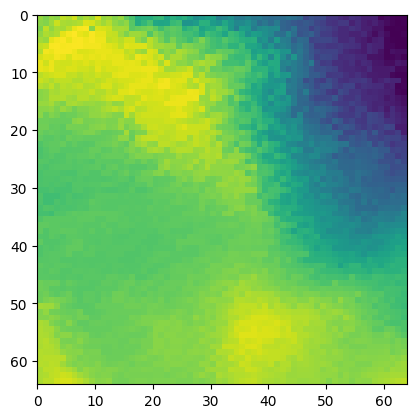

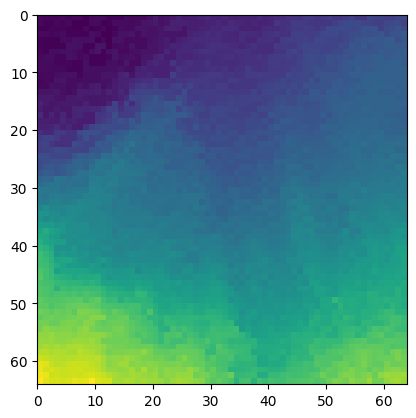

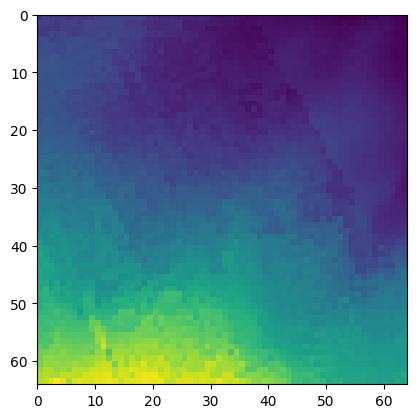

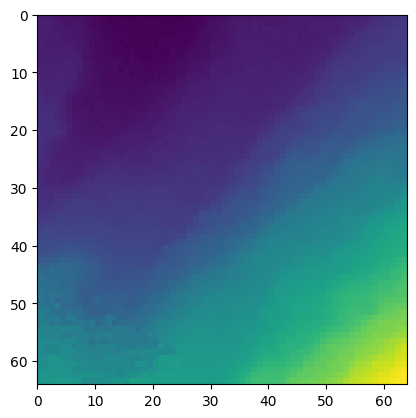

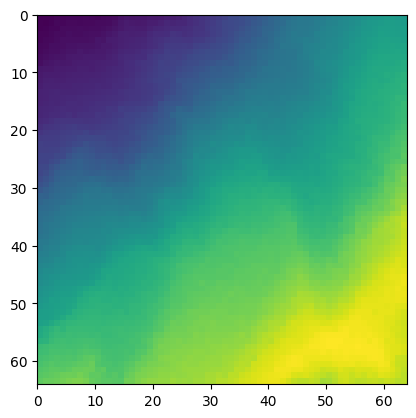

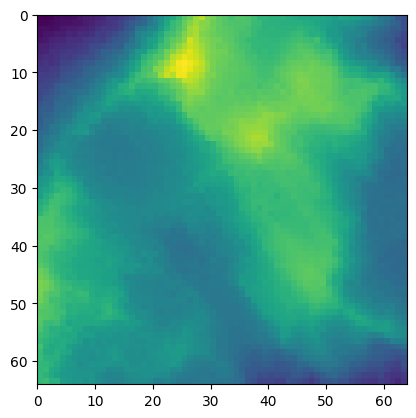

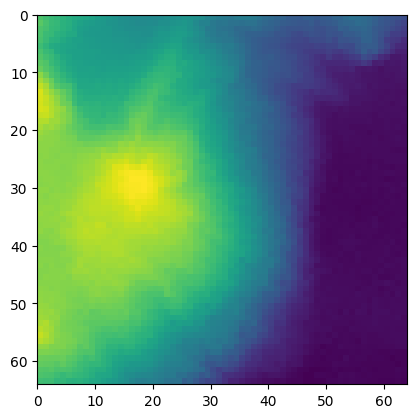

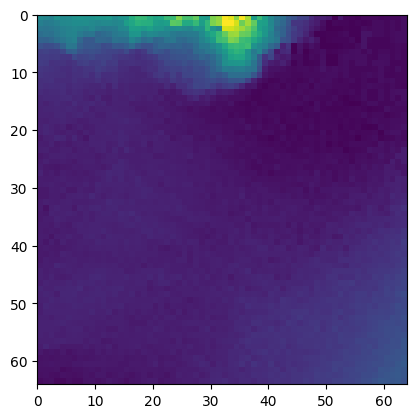

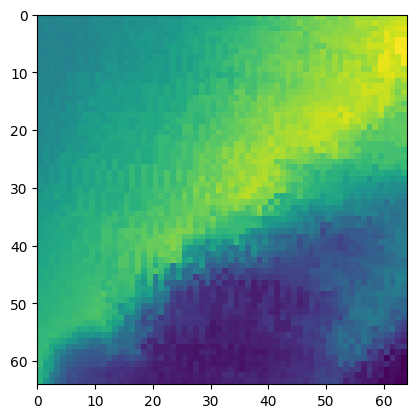

In [224]:
for index in range(10):
  fp = r'/content/drive/MyDrive/GISR_code/dataset/lr_test_'+ str(index) + '.tif'
  img = rasterio.open(fp)
  show(img)

In [3]:
# for i in images_tiles:
#   print(i.shape)

## Use the model to get HR 

In [226]:
for i in range(len(images_tiles)):
  filename=DATBASE_PATH+"/lr_test_"
  img_hr= io.imread(filename+str(i)+'.tif')
  a=img_hr
  a1 = a
  a111 = a[:,:64]
  a2 = (a1) / ((103302.82-0) / 2) - 1
  a3 = np.expand_dims(a2, 0)
  a4 = np.expand_dims(a3, 0)
  a5 = a4.astype(np.float32)
  a6 = torch.tensor(a5)
  Tensor = torch.cuda.FloatTensor
  a7 = Variable(a6.type(Tensor))
  a8 = generator(a7)
  a9=(a8+a7)/2
  a10 = (a9+1)*((h - l) / 2)
  a11 = a10.cpu().detach().numpy()
  tiff.imwrite(DATBASE_PATH+"gene_hr"+str(i)+'.tif', a11[0,0,:,:])

# Visualize HR results

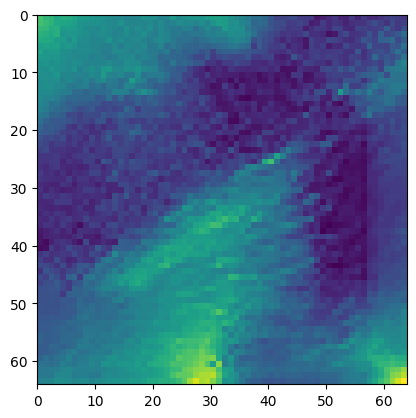

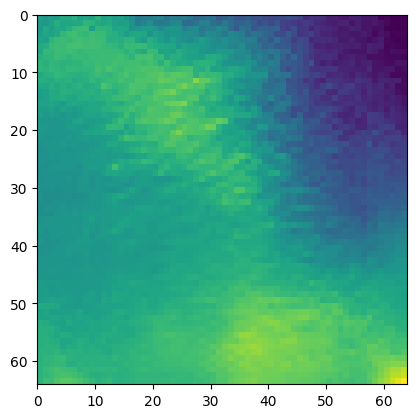

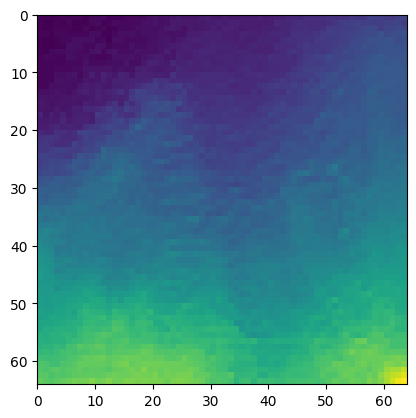

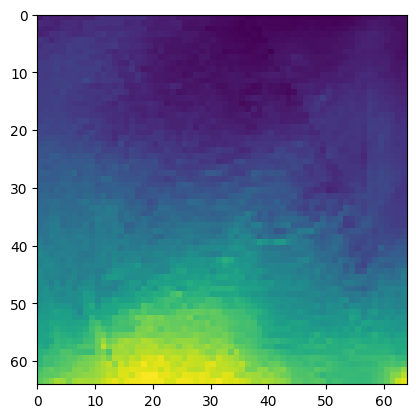

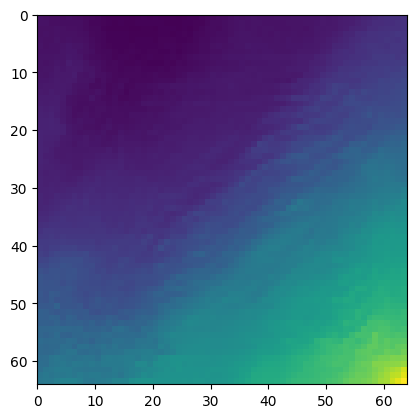

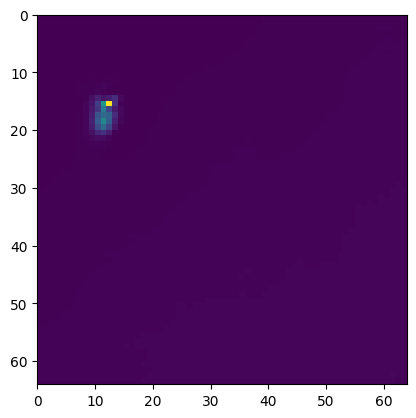

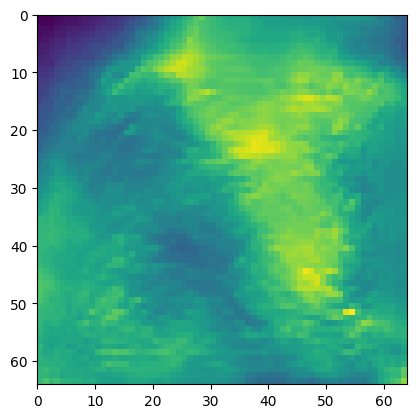

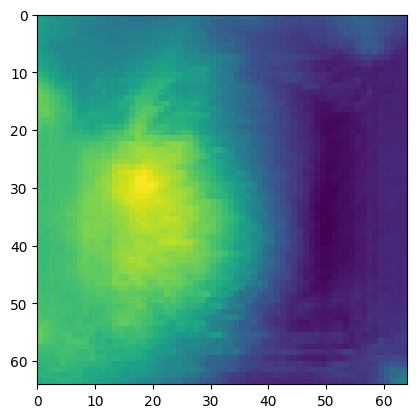

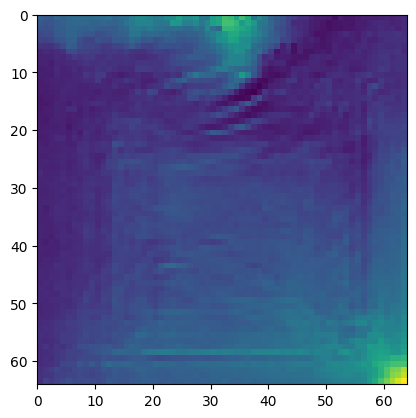

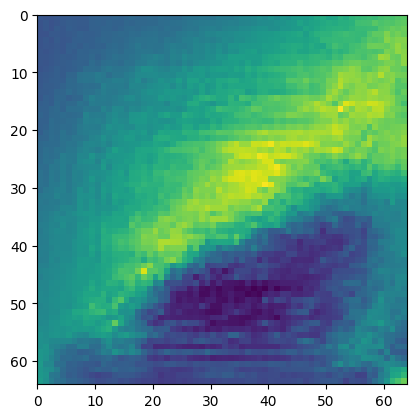

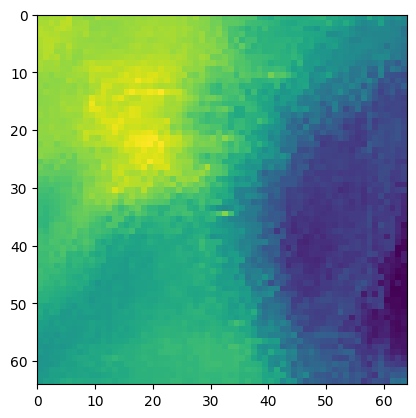

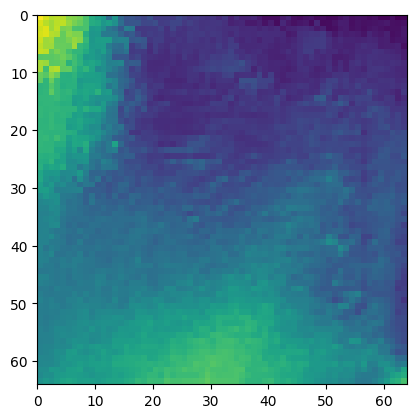

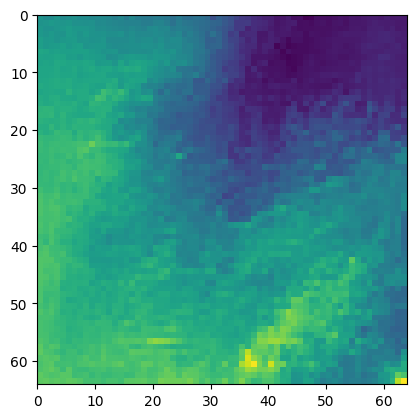

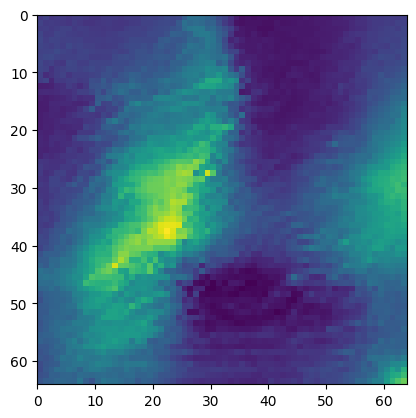

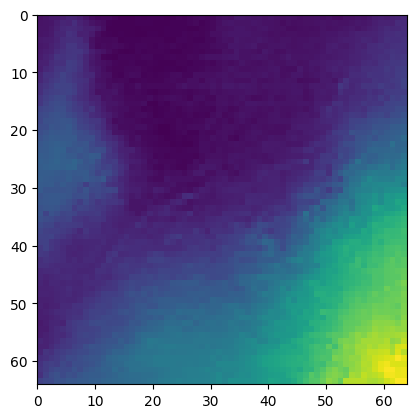

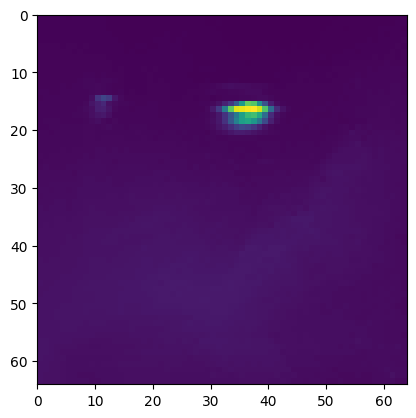

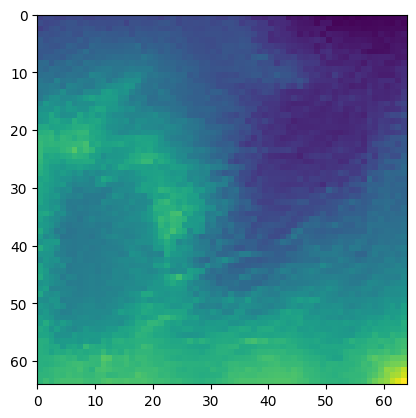

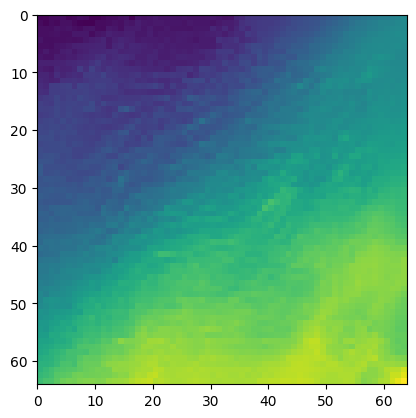

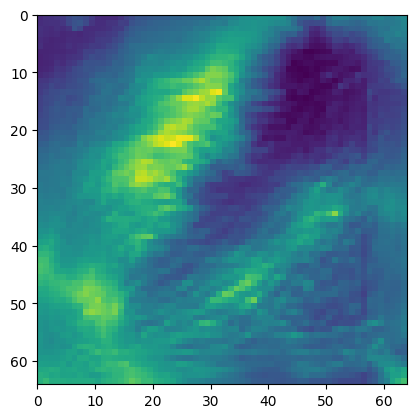

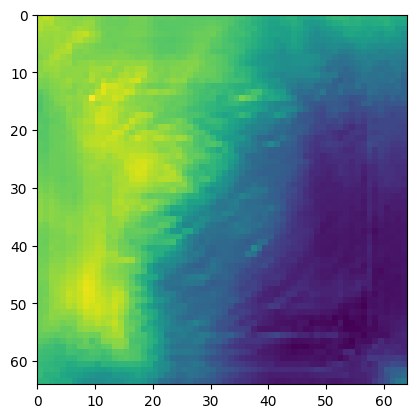

In [227]:
#generated image
import rasterio
from  rasterio.plot import show
for index in range(20):
  fp = r'/content/drive/MyDrive/GISR_code/dataset/gene_hr'+ str(index) + '.tif'
  img = rasterio.open(fp)
  show(img)

## Recover the original image

In [228]:
gene_images_tiles=[]
for index in range(len(images_tiles)):
  fp = r'/content/drive/MyDrive/GISR_code/dataset/gene_hr'+ str(index) + '.tif'
  img = rasterio.open(fp)
  gene_images_tiles.append(np.squeeze(img.read()))

In [4]:
# for i in gene_images_tiles:
#   print(i.shape)

In [150]:
len(added_col_or_arr_number)

24

In [230]:
operation_type

['columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'columns added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows added',
 'rows and columns added']

In [231]:
#This code recovers the original tiles' shape (because not all original images are 64x64)
for index_index, index in enumerate(tiles_index):
  if operation_type[index_index]=='columns added':
    n=added_col_or_arr_number[index_index]
    gene_images_tiles[index]=gene_images_tiles[index][:, n:]
  if operation_type[index_index]=='rows added':
    n=added_col_or_arr_number[index_index]
    gene_images_tiles[index]=gene_images_tiles[index][n:, :]
  if operation_type[index_index]=='rows and columns added':
    n_w,n_h=added_col_or_arr_number_last_tile[0],added_col_or_arr_number_last_tile[1]
    gene_images_tiles[-1]=gene_images_tiles[-1][:, n_w:]
    gene_images_tiles[-1]=gene_images_tiles[-1][n_h:,:]
    

In [5]:
# for i in gene_images_tiles:
#   print(i.shape)

In [233]:
path="/content/drive/MyDrive/GISR_code/dataset/"
index=0
for img in  gene_images_tiles:
  tiff.imwrite(path +'/'+'original_hr_'+ str(index) + '.tif', img)
  index+=1

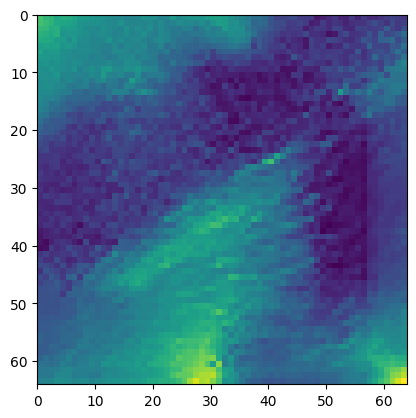

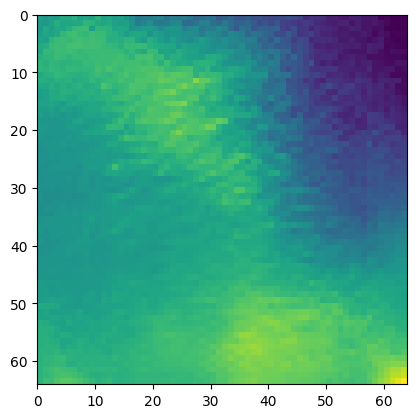

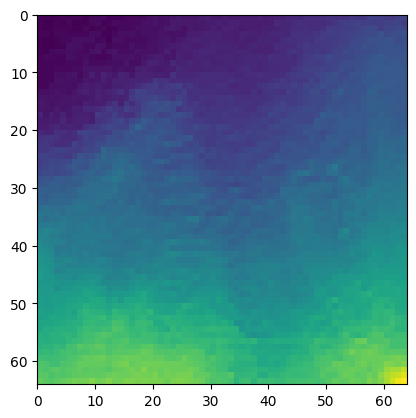

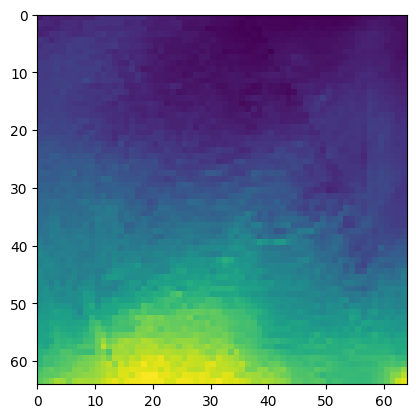

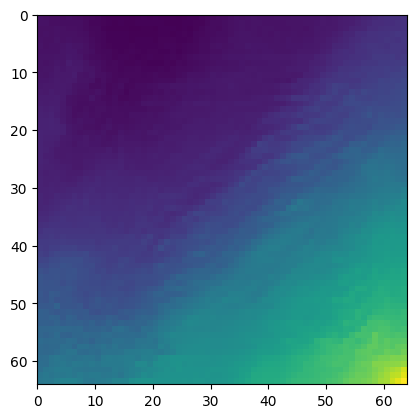

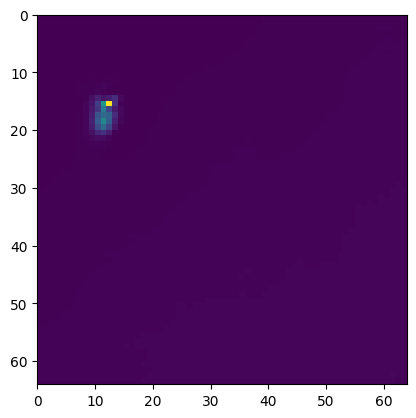

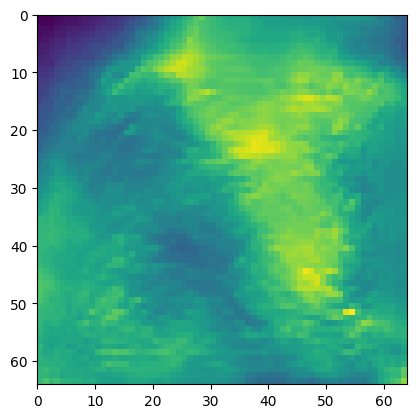

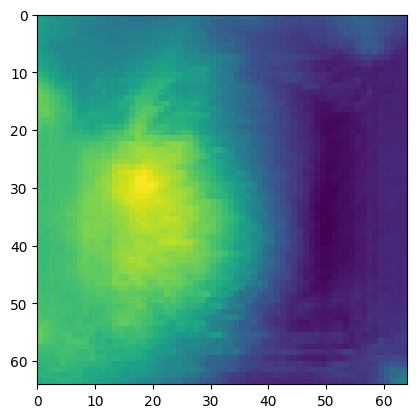

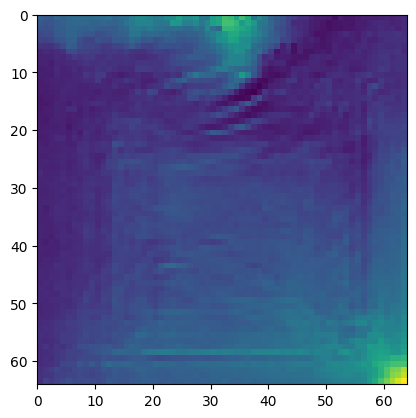

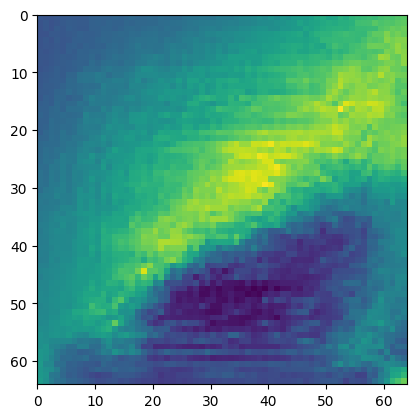

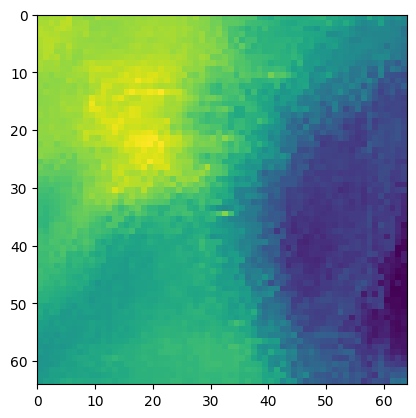

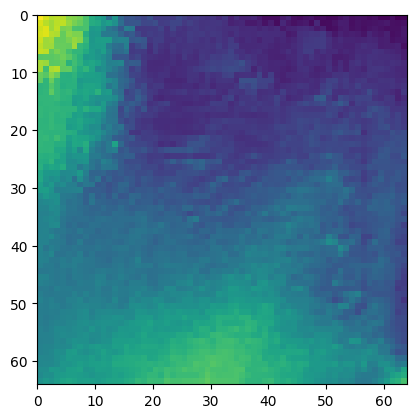

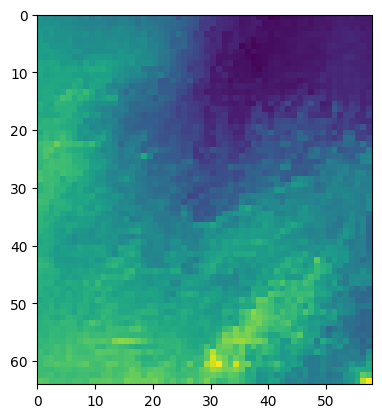

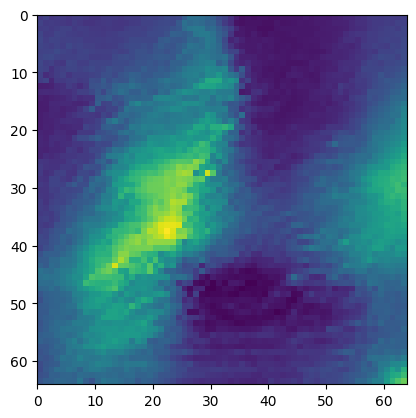

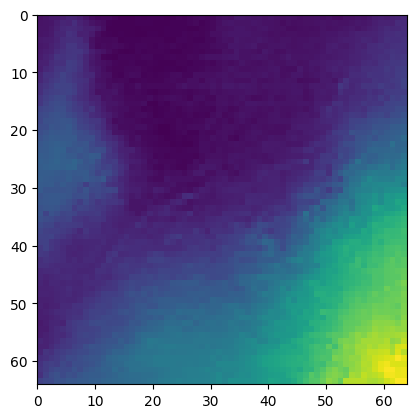

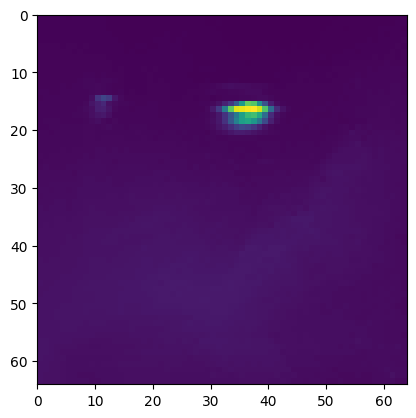

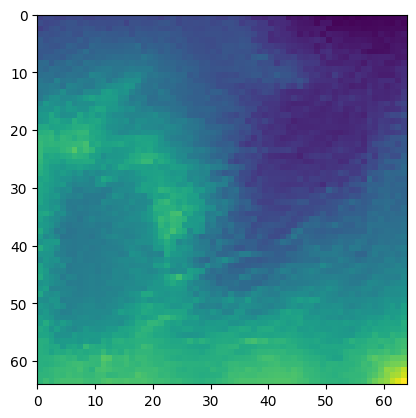

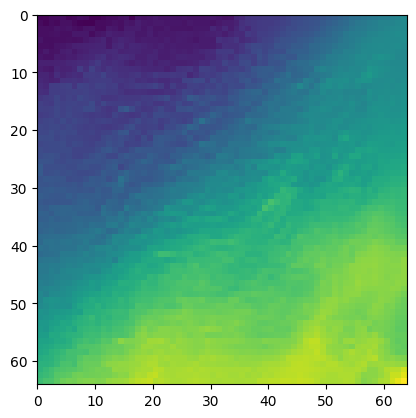

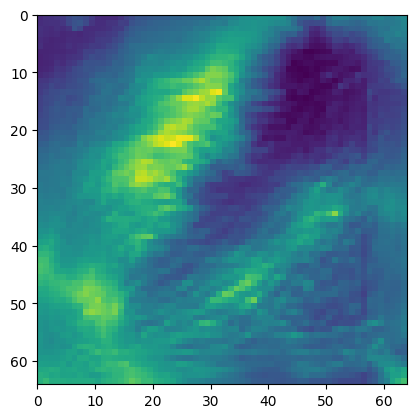

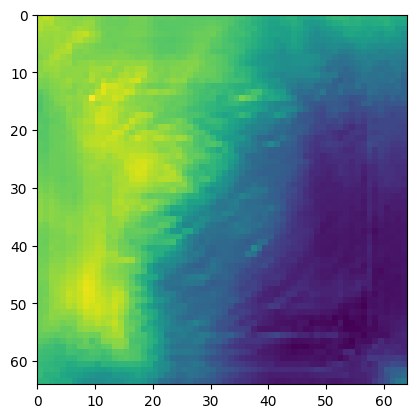

In [234]:
for index in range(20):
  fp = r'/content/drive/MyDrive/GISR_code/dataset/original_hr_'+ str(index) + '.tif'
  img = rasterio.open(fp)
  show(img)

In [236]:
#function to recover the original image of (812 * 826)
H,W=img_lr.shape
if W%M==0:
    n_w=int(W/M)
else:
    n_w=int(W/M)+1
if H%N==0:
    n_h=int(H/N)
else:
    n_h=int(H/N)+1
reversed_array_h=[]
a=0
for i in range(n_h):
    split_arrays=[]
    for j in range(a,n_w+a):
        split_arrays.append(gene_images_tiles[j])
    reversed_array = np.concatenate(split_arrays, axis=1) # Concatenate the split arrays horizontally
    reversed_array_h.append(reversed_array )
    a=j+1
reversed_array_final = np.concatenate(reversed_array_h, axis=0)
tiff.imwrite(path +'/gene_test_imge.tif', reversed_array_final)
print(reversed_array_final.shape)

(812, 826)
